In [1]:
!pip install transformers
!pip install kagglehub

# NLP Tweet Sentiment Analysis

The purpose of this project is to fine-tuned Hugging Face transformer-based sentiment analysis models (DistilBERT and RoBERTa) to capture more nuanced sentiment in text data.

Prepared by Raphael Lu

In [2]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#HuggingFace tools
from transformers import DistilBertTokenizer, DistilBertModel
from transformers import AutoTokenizer, AutoModel, Trainer, TrainingArguments

2025-11-17 03:18:06.614084: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Device Loading

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device Loaded: {device}")

Device Loaded: cuda


In [4]:
torch.manual_seed(42)
np.random.seed(42)
torch.cuda.manual_seed_all(42)

In [5]:

distil_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")


Next, we set random seeds to ensure reproducibility, meaning that everytime the code runs, it produces the same results. This helps maintain consistency across experiments and makes debugging or comparision between models more reliable.

# Data Preprocessing:

Summary of Data Preprocessing  
  - Fields were renamed `id`, `text`, and `label`
  - `id` field was ultimately dropped
  - Target labels were re-coded into arrays using `MultiLabelBinarizer`:
    - e.g. with sentiments

      `['angry' 'disgust' 'happy' 'nocode' 'not-relevant' 'sad' 'surprise']`, a tensor of `[1 0 0 0 0 1 0]` indicates an `angry|sad` tweet
  - Data were split using a 80:20 (train:test) ratio and stored in `X_train, X_test, y_train, y_test`


## Inital Data View

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("parulpandey/emotion-dataset")

print("Path to dataset files:", path)

Path to dataset files: /home/sagemaker-user/.cache/kagglehub/datasets/parulpandey/emotion-dataset/versions/1


In [4]:
import pandas as pd

# Load the .txt files (they're actually CSV-like with ';' separator)
train_df = pd.read_csv(os.path.join(path, 'training.txt'), 
                       sep=';', 
                       names=['text', 'emotion'],
                       header=None)

val_df = pd.read_csv(os.path.join(path, 'val.txt'), 
                     sep=';', 
                     names=['text', 'emotion'],
                     header=None)

test_df = pd.read_csv(os.path.join(path, 'test.txt'), 
                      sep=';', 
                      names=['text', 'emotion'],
                      header=None)

print(f"Train: {train_df.shape}")
print(f"Val: {val_df.shape}")
print(f"Test: {test_df.shape}")
print("\nSample:")
print(train_df.head())

Files in dataset:
test.csv
validation.csv


#### `nocode` label

It appears that a many `nocode` labels are attributed to news and event announcements

In [8]:
print(df[['text','label']][df['label']=='nocode'].sample(15, random_state=42))

                                                   text   label
2221  Read our new article about #Periscope &amp; @b...  nocode
1620  @sallyfryer1 @karolinaglusiec is putting all o...  nocode
2305  Go see Art in Dialogue: Duccio | Caro @Nationa...  nocode
1072  As @kettlesyard prepares to close for two year...  nocode
1041  I'm at @BritishMuseum in London, Greater Londo...  nocode
2979  @RomanBinchester Reminds me of this pendant I ...  nocode
1054  Volunteers needed for ARTIST ROOMS: Gerhard Ri...  nocode
562   Tiger in a Tropical Storm (Surprised), by Henr...  nocode
1005  Visit Giovanni di Paolo's four #BapistPredella...  nocode
128   Artist Larissa Sansour discusses the use of sc...  nocode
1351  @britishmuseum Any chances of #DefiningBeauty ...  nocode
2998  @MrStuchbery @britishmuseum I'm guessing Mesoa...  nocode
2948  Join our Index Editor Barbara Pezzini this lun...  nocode
1558  James Richards composes a sonic score for a Fr...  nocode
2016  MT @britishmuseum: @britishlibrary

## Tweet Pre-processing
* Tweets were processed using recommened method in model [documentation](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment).
     * Specifically usernames and hyperlinks were reduced to `@user` and `http` respectively
* Tweets were tokenized and stored in X2_train and X2_test

In [9]:
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [10]:
df_view = df.copy()
df['text'] = df_view['text'].apply(preprocess)

display(df_view['text'].head(2))

0    @aandraous @britishmuseum @AndrewsAntonio Merc...
1    Dorian Gray with Rainbow Scarf #LoveWins (from...
Name: text, dtype: object

### Instantiate the TweetDataset class

In [11]:
class TweetDataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len, mlb=None):
    self.len = len(dataframe)
    self.df = dataframe.reset_index(drop=True)
    self.tokenizer = tokenizer
    self.max_len = max_len
    self.mlb = mlb

  def preprocess(self, text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

  def __getitem__(self,index):
    text = str(self.df.iloc[index,0])
    text = self.preprocess(text)

    inputs = self.tokenizer.encode_plus(
        text,
        None, #account for how encode_plus() takes second sentence
        add_special_tokens=True,
        max_length=self.max_len,
        padding='max_length',
        return_token_type_ids=True,
        truncation=True
    )

    ids = inputs['input_ids']
    mask = inputs['attention_mask']

    if self.mlb == None:
      labels = self.df.iloc[index, 1]
    else:
      labels_str = str(self.df.iloc[index, 1])
      labels = self.mlb.transform([labels_str.split('|')])[0]


    return {
        'ids': torch.tensor(ids, dtype=torch.long),
        'mask': torch.tensor(mask, dtype=torch.long),
        'labels': torch.tensor(labels, dtype=torch.float)
    }

  def __len__(self):
    return self.len



## Train-Test-Split

In [12]:
# print(mlb.classes_)
# print(y_train[42])

In [13]:
if 'id' in df.columns:
    df = df.drop('id', axis=1)

# df = df.drop('id', axis=1)

train_size = 0.8
train_df = df.sample(frac=train_size,random_state=42)
test_df = df.drop(train_df.index).reset_index(drop=True)

train_df = train_df.reset_index(drop=True)

print("Full dataset: {}".format(df.shape))
print("Train dataset: {}".format(train_df.shape))
print("Test dataset: {}".format(test_df.shape))

train_df

Full dataset: (3085, 2)
Train dataset: (2468, 2)
Test dataset: (617, 2)


,text,label
0,pindah lagi ehehe (at @user — http,nocode
1,@user @user @user @user @user @user Thank you :-),happy
2,"Roman gem engraved with Odysseus, his ship, an...",nocode
3,An exciting announcement soon :) @user #excited,happy
4,Excited to have a FLASH Residency at @user thi...,happy
...,...,...
2463,Researcher @user discussed 3D imaging cultural...,nocode
2464,@user Egon Schiele - at the moment.,nocode
2465,@user @user It has long been on list to visit....,nocode
2466,"""@Cambscene: Watercolour - Elements of Nature ...",nocode


In [14]:
MAX_LEN = 512
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 2

train_parameters = {
    'batch_size' : TRAIN_BATCH_SIZE,
    'shuffle':True,
    'num_workers':0
}

test_parameters = {
    'batch_size' : VALID_BATCH_SIZE,
    'shuffle':True,
    'num_workers':0
}

# Sentiment Distribution

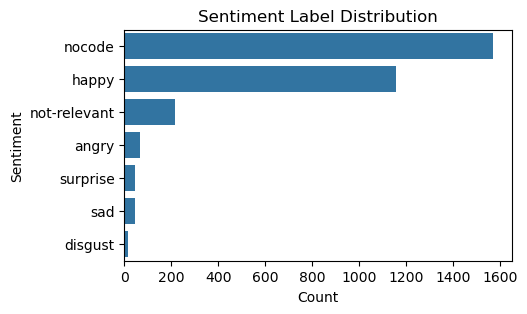

In [15]:
sentiment_labels = pd.DataFrame(df['label'].str.split('|'))
exploded_labels = sentiment_labels.explode('label')

plt.figure(figsize=(5, 3))
sns.countplot(y=exploded_labels['label'], order=exploded_labels['label'].value_counts().index)
plt.title("Sentiment Label Distribution")
plt.xlabel("Count")
plt.ylabel("Sentiment")
plt.show()

## DistilBERT Sentiment Analysis


### Tokenization

In [20]:
distil_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")


In [21]:
mlb = MultiLabelBinarizer()
mlb.fit(train_df['label'].str.split('|'))


,classes,None
,sparse_output,False


In [22]:
distil_training_set = TweetDataset(dataframe=train_df,
                            tokenizer = distil_tokenizer,
                            max_len = MAX_LEN,
                            mlb=mlb)

distil_testing_set = TweetDataset(dataframe=test_df,
                            tokenizer = distil_tokenizer,
                            max_len = MAX_LEN,
                            mlb=mlb)

In [23]:
distil_training_loader = DataLoader(distil_training_set,
                                    **train_parameters)

distil_testing_loader = DataLoader(distil_testing_set,
                                   **test_parameters)

### Building the distilBERT Classifier

In [24]:
class DistilBERTClass(torch.nn.Module):
  def __init__(self, num_labels = 7):
    super().__init__()

    self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

    self.classifier = torch.nn.Sequential(
        torch.nn.Linear(768,768),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.4),
        torch.nn.Linear(768,num_labels)
    )

  def forward(self, input_ids, attention_mask):
    output_0 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
    hidden_state = output_0[0]
    pooler = hidden_state[:,0]
    output = self.classifier(pooler)
    return output




### distilBERT Train - Valid Functions

In [25]:
def calc_accu(outputs,targets,threshold = 0.5):
  preds = (torch.sigmoid(outputs) > treshold).float()
  n_correct = (preds == targets).sum().item()
  return n_correct / targets.numel()

def train(epochs, model, device, training_loader, optimizer, loss_function, threshold=0.5):

  tr_loss = 0
  n_correct = 0
  nb_tr_examples = 0
  nb_tr_steps = 0

  model.train()

  for _,data in enumerate(training_loader, 0): # triggers training loader _ number batch and data
    ids = data['ids'].to(device, dtype=torch.long)
    mask = data['mask'].to(device, dtype=torch.long)
    targets = data['labels'].to(device, dtype=torch.float)

    outputs = model(ids,mask)

    loss = loss_function(outputs, targets)
    tr_loss += loss.item()

    preds = (torch.sigmoid(outputs) > threshold).float()
    n_correct += (preds == targets).sum().item()

    nb_tr_steps += 1
    nb_tr_examples += targets.size(0)

    if _ %5000 == 0:
        loss_step = tr_loss/nb_tr_steps
        total_predictions = nb_tr_examples * targets.size(1)  # targets.size(1) = num_labels (e.g., 7)
        accu_step = (n_correct * 100) / total_predictions
        print(f"Training loss per 5000 steps: {loss_step}")
        print(f"Training Accuracy per 5000 steps: {accu_step}")

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

  epoch_loss = tr_loss / nb_tr_steps
  num_labels = targets.size(1)
  total_predictions = nb_tr_examples * num_labels
  epoch_accu = (n_correct * 100) / total_predictions
  print(f"Training Loss Epoch: {epoch_loss}")
  print(f"Training accuracy Epoch: {epoch_accu}")

  return

In [26]:
def valid(epochs, model, device, testing_loader, optimizer, loss_function, threshold=0.5):
  model.eval()

  n_correct = 0
  ts_loss = 0
  nb_ts_examples = 0
  nb_ts_correct = 0
  nb_ts_steps = 0

  with torch.no_grad():

    for _,data in enumerate(testing_loader):
      ids = data['ids'].to(device, dtype= torch.long)
      mask = data['mask'].to(device, dtype= torch.long)
      targets = data['labels'].to(device, dtype= torch.float)

      outputs = model(ids,mask)

      loss = loss_function(outputs, targets)
      ts_loss += loss.item()

      preds = (torch.sigmoid(outputs) > threshold).float()
      n_correct += (preds == targets).sum().item()

      nb_ts_steps += 1
      nb_ts_examples += targets.size(0)

      if _ % 1000 == 0:
        loss_step = ts_loss / nb_ts_steps
        total_predictions = nb_ts_examples * targets.size(1)
        accu_step = (n_correct * 100) / total_predictions
        print(f"Testing loss per 1000 steps: {loss_step}")
        print(f"Testing Accuracy per 1000 steps: {accu_step}")

  epoch_loss = ts_loss / nb_ts_steps
  num_labels = targets.size(1)
  total_predictions = nb_ts_examples * num_labels
  epoch_accu = (n_correct*100) / total_predictions
  print(f"Testing Loss Epoch: {epoch_loss}")
  print(f"Testing accuracy Epoch: {epoch_accu}")



### Training

In [27]:
model_1 = DistilBERTClass().to(device)

In [28]:
LEARNING_RATE = 1e-05
TRAIN_EPOCHS = 8

loss_function = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params= model_1.parameters(), lr=LEARNING_RATE)

In [29]:
for epoch in range(TRAIN_EPOCHS):
    print()
    print(f"starting epoch: {epoch}")

    train(epoch, model_1, device, distil_training_loader, optimizer, loss_function)


starting epoch: 0
Training loss per 5000 steps: 0.6660293340682983
Training Accuracy per 5000 steps: 67.85714285714286
Training Loss Epoch: 0.2688107507082979
Training accuracy Epoch: 91.81523500810373

starting epoch: 1
Training loss per 5000 steps: 0.09028608351945877
Training Accuracy per 5000 steps: 100.0
Training Loss Epoch: 0.15793980404167063
Training accuracy Epoch: 95.05093771706413

starting epoch: 2
Training loss per 5000 steps: 0.06608613580465317
Training Accuracy per 5000 steps: 100.0
Training Loss Epoch: 0.12006853327964172
Training accuracy Epoch: 96.3070155128502

starting epoch: 3
Training loss per 5000 steps: 0.037055760622024536
Training Accuracy per 5000 steps: 100.0
Training Loss Epoch: 0.09575609234727714
Training accuracy Epoch: 97.00162074554295

starting epoch: 4
Training loss per 5000 steps: 0.037850022315979004
Training Accuracy per 5000 steps: 100.0
Training Loss Epoch: 0.07354752030419835
Training accuracy Epoch: 97.70201435517481

starting epoch: 5
Train

### Testing

In [30]:
TEST_EPOCHS = 3

for epoch in range(TEST_EPOCHS):
    print()
    print(f"starting epoch: {epoch}")

    valid(epoch, model_1, device, distil_testing_loader, optimizer, loss_function)



starting epoch: 0
Testing loss per 1000 steps: 0.05632207542657852
Testing Accuracy per 1000 steps: 100.0
Testing Loss Epoch: 0.22773958741186917
Testing accuracy Epoch: 93.98008798332947

starting epoch: 1
Testing loss per 1000 steps: 0.047591015696525574
Testing Accuracy per 1000 steps: 100.0
Testing Loss Epoch: 0.22961747214653225
Testing accuracy Epoch: 93.98008798332947

starting epoch: 2
Testing loss per 1000 steps: 0.0018367563607171178
Testing Accuracy per 1000 steps: 100.0
Testing Loss Epoch: 0.22773746768627495
Testing accuracy Epoch: 93.98008798332947


In [31]:
model_1_state = model_1.state_dict()
print("Model state saved to variable 'model_state'")

Model state saved to variable 'model_state'


In [32]:
# model_state

# roBERTa Sentiment Analysis

## Tokenization

In [33]:
roberta_tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")

In [34]:
roberta_training_set = TweetDataset(dataframe=train_df,
                            tokenizer = roberta_tokenizer,
                            max_len = MAX_LEN,
                            mlb=mlb)

roberta_testing_set = TweetDataset(dataframe=test_df,
                            tokenizer = roberta_tokenizer,
                            max_len = MAX_LEN,
                            mlb=mlb)

In [35]:
roberta_training_loader = DataLoader(roberta_training_set,
                                    **train_parameters)

roberta_testing_loader = DataLoader(roberta_testing_set,
                                   **test_parameters)

## Building the roBERTa Classifier

In [36]:
class roBERTaCLASS(torch.nn.Module):
  def __init__(self, num_labels=7):
    super().__init__()

    self.l1 = AutoModel.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")

    self.classifier = torch.nn.Sequential(
        torch.nn.Linear(768,768),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.3),
        torch.nn.Linear(768, num_labels)
    )

  def forward(self, input_ids, attention_mask):
    output_0 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
    hidden_state = output_0[0]
    pooler = hidden_state[:,0]
    output = self.classifier(pooler)
    return output

## Training

In [37]:
model_2 = roBERTaCLASS().to(device)

In [38]:
LEARNING_RATE = 1e-05
TRAIN_EPOCHS = 8

loss_function = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params= model_1.parameters(), lr=LEARNING_RATE)

In [39]:
for epoch in range(TRAIN_EPOCHS):
    print()
    print(f"starting epoch: {epoch}")

    train(epoch, model_2, device, roberta_training_loader, optimizer, loss_function)


starting epoch: 0
Training loss per 5000 steps: 0.6601042151451111
Training Accuracy per 5000 steps: 71.42857142857143
Training Loss Epoch: 0.6480635033627576
Training accuracy Epoch: 70.14355174808983

starting epoch: 1
Training loss per 5000 steps: 0.6508499979972839
Training Accuracy per 5000 steps: 71.42857142857143
Training Loss Epoch: 0.6484363235569464
Training accuracy Epoch: 69.77888400092614

starting epoch: 2
Training loss per 5000 steps: 0.6540669202804565
Training Accuracy per 5000 steps: 67.85714285714286
Training Loss Epoch: 0.6497248786001962
Training accuracy Epoch: 69.76151887010882

starting epoch: 3
Training loss per 5000 steps: 0.6418432593345642
Training Accuracy per 5000 steps: 60.714285714285715
Training Loss Epoch: 0.6500363769175748
Training accuracy Epoch: 69.70363510071776

starting epoch: 4
Training loss per 5000 steps: 0.6444116830825806
Training Accuracy per 5000 steps: 71.42857142857143
Training Loss Epoch: 0.6486396152930669
Training accuracy Epoch: 70

In [40]:
TEST_EPOCHS = 3

for epoch in range(TEST_EPOCHS):
    print()
    print(f"starting epoch: {epoch}")

    valid(epoch, model_2, device, roberta_testing_loader, optimizer, loss_function)


starting epoch: 0
Testing loss per 1000 steps: 0.6106739044189453
Testing Accuracy per 1000 steps: 92.85714285714286
Testing Loss Epoch: 0.6457667746204389
Testing accuracy Epoch: 73.90599675850892

starting epoch: 1
Testing loss per 1000 steps: 0.634590744972229
Testing Accuracy per 1000 steps: 78.57142857142857
Testing Loss Epoch: 0.6457715522509948
Testing accuracy Epoch: 73.90599675850892

starting epoch: 2
Testing loss per 1000 steps: 0.6657352447509766
Testing Accuracy per 1000 steps: 71.42857142857143
Testing Loss Epoch: 0.6458450019552484
Testing accuracy Epoch: 73.90599675850892


In [42]:
import torch
import boto3

def save_to_s3(model, s3_url, filename='model_state.pth'):
    """Save model state dict to S3 URL"""
    
    # Save model locally
    torch.save(model.state_dict(), filename)
    
    # Clean and parse S3 URL
    s3_path = s3_url.replace('s3://', '').rstrip('/')  # remove trailing slash
    bucket, *path_parts = s3_path.split('/')
    prefix = '/'.join(path_parts)  # path after bucket
    
    # Final S3 key
    s3_key = f"{prefix}/{filename}" if prefix else filename
    
    # Upload file
    boto3.client('s3').upload_file(filename, bucket, s3_key)
    print(f"✓ Saved to s3://{bucket}/{s3_key}")
    
    return f"s3://{bucket}/{s3_key}"


In [43]:
save_to_s3(
    model_1,
    's3://hugging-face-multiclass-textclassification-bucket-raphael/output/tweet_sentiments',
    filename='model_state_1.pth'
)



✓ Saved to s3://hugging-face-multiclass-textclassification-bucket-raphael/output/tweet_sentiments/model_state_1.pth
✓ Saved to s3://hugging-face-multiclass-textclassification-bucket-raphael/output/tweet_sentiments/model_state_2.pth


's3://hugging-face-multiclass-textclassification-bucket-raphael/output/tweet_sentiments/model_state_2.pth'

### Additional 8 Epochs

In [44]:
for epoch in range(TRAIN_EPOCHS):
    print()
    print(f"starting epoch: {epoch}")

    train(epoch, model_2, device, roberta_training_loader, optimizer, loss_function)


starting epoch: 0
Training loss per 5000 steps: 0.6596491932868958
Training Accuracy per 5000 steps: 67.85714285714286
Training Loss Epoch: 0.6495199427612404
Training accuracy Epoch: 69.92359342440379

starting epoch: 1
Training loss per 5000 steps: 0.654768705368042
Training Accuracy per 5000 steps: 67.85714285714286
Training Loss Epoch: 0.6491706861089462
Training accuracy Epoch: 69.85413290113452

starting epoch: 2
Training loss per 5000 steps: 0.6540298461914062
Training Accuracy per 5000 steps: 67.85714285714286
Training Loss Epoch: 0.6486562752259994
Training accuracy Epoch: 70.2014355174809

starting epoch: 3
Training loss per 5000 steps: 0.6380781531333923
Training Accuracy per 5000 steps: 67.85714285714286
Training Loss Epoch: 0.648887897909557
Training accuracy Epoch: 69.9178050474647

starting epoch: 4
Training loss per 5000 steps: 0.6261258125305176
Training Accuracy per 5000 steps: 75.0
Training Loss Epoch: 0.6492831286773496
Training accuracy Epoch: 69.83676777031721

s

In [45]:
TEST_EPOCHS = 3

for epoch in range(TEST_EPOCHS):
    print()
    print(f"starting epoch: {epoch}")

    valid(epoch, model_2, device, roberta_testing_loader, optimizer, loss_function)


starting epoch: 0
Testing loss per 1000 steps: 0.6584963798522949
Testing Accuracy per 1000 steps: 64.28571428571429
Testing Loss Epoch: 0.6458245554402422
Testing accuracy Epoch: 73.90599675850892

starting epoch: 1
Testing loss per 1000 steps: 0.6513847708702087
Testing Accuracy per 1000 steps: 78.57142857142857
Testing Loss Epoch: 0.6457936796555627
Testing accuracy Epoch: 73.90599675850892

starting epoch: 2
Testing loss per 1000 steps: 0.6701233983039856
Testing Accuracy per 1000 steps: 71.42857142857143
Testing Loss Epoch: 0.645746678210385
Testing accuracy Epoch: 73.90599675850892


In [46]:
save_to_s3(
    model_2,
    's3://hugging-face-multiclass-textclassification-bucket-raphael/output/tweet_sentiments',
    filename='model_state_2.pth'
)


✓ Saved to s3://hugging-face-multiclass-textclassification-bucket-raphael/output/tweet_sentiments/model_state_2.pth


's3://hugging-face-multiclass-textclassification-bucket-raphael/output/tweet_sentiments/model_state_2.pth'